C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\

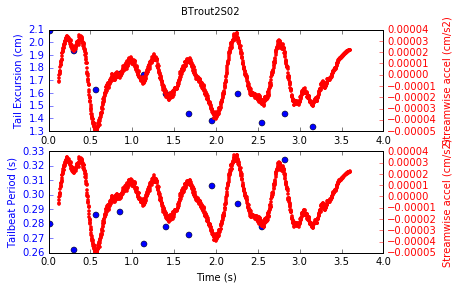

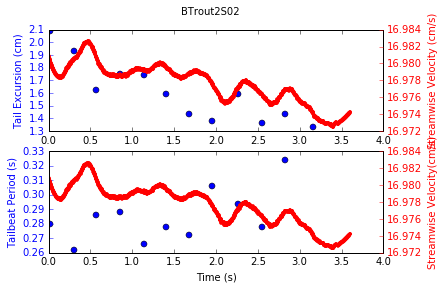

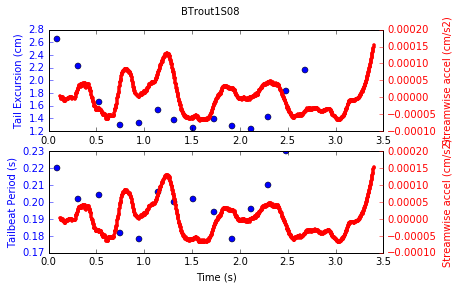

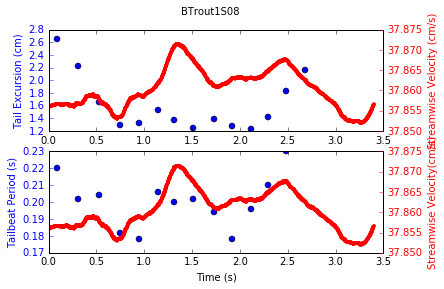

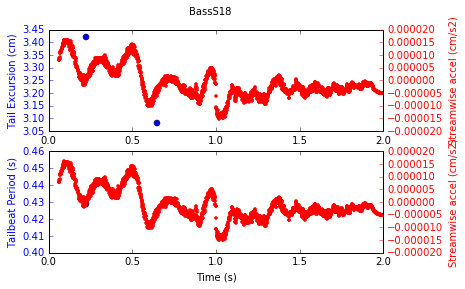

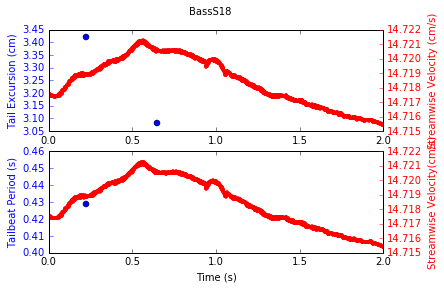

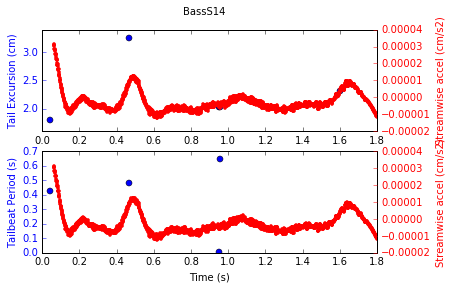

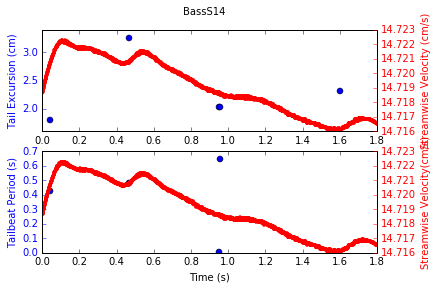

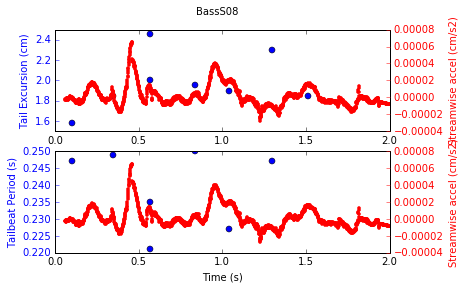

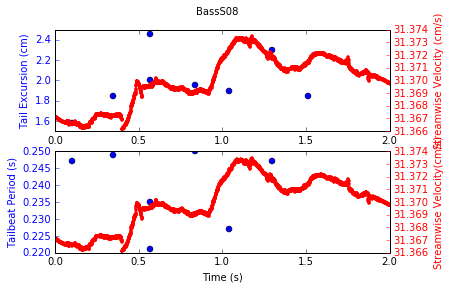

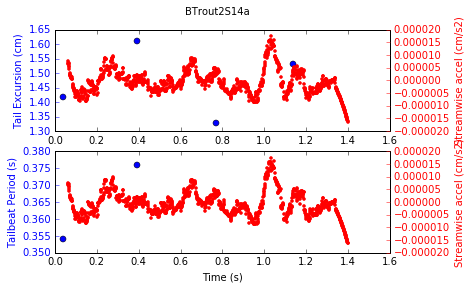

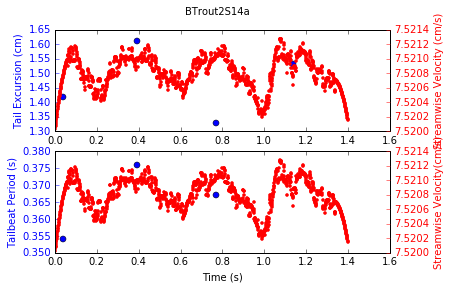

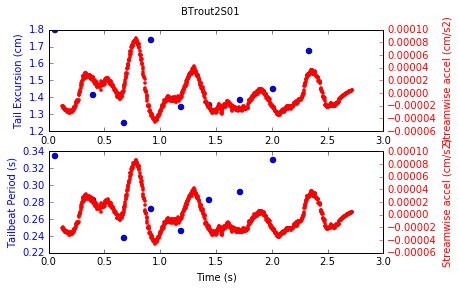

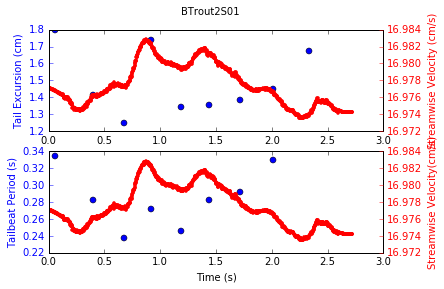

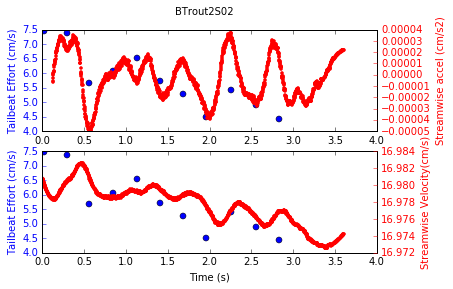

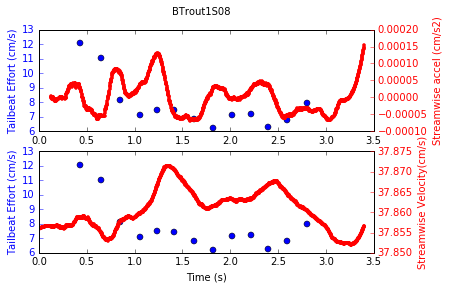

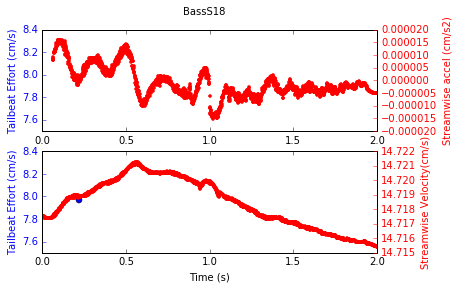

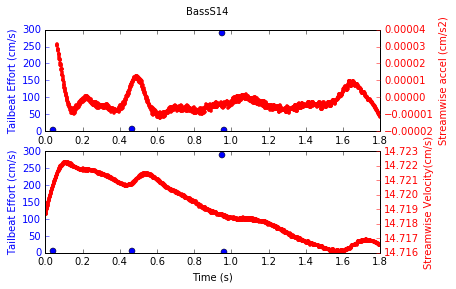

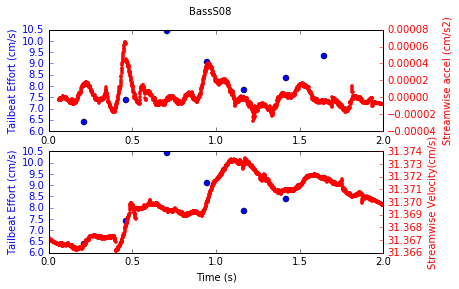

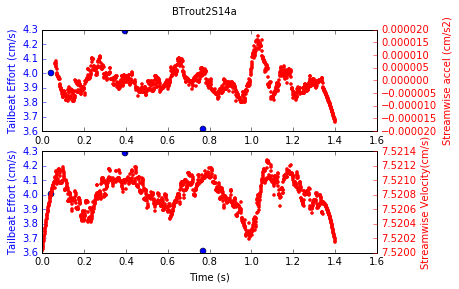

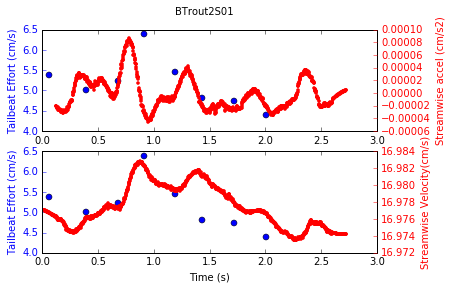

In [13]:
# Load all of the things
import tkinter as tk
import os
from tkinter import filedialog  # For folder input popup
import pandas as pd
import numpy as np
import scipy
from scipy.signal import savgol_filter  # for smoothing data
from scipy.fftpack import fft
from scipy.fftpack import fftfreq
import matplotlib
matplotlib.rc('axes.formatter', useoffset=False)
from mpl_toolkits.mplot3d import Axes3D
import sys
import matplotlib.pyplot as plt
import peakutils
from peakutils.plot import plot as pplot
import matplotlib.cm as cm
%matplotlib inline  

root = tk.Tk()
root.withdraw()

######################################################################
# Data Extraction
######################################################################
trial_info = pd.read_csv('D:/Acceleration/Digitized tracks/Trial_info.csv',
                         sep=',')
trial_info = trial_info.set_index('Trial_name')
folder = 'D:/Acceleration/Digitized tracks'  # comment out for user input

#  Uncomment for User Input
# folder = filedialog.askdirectory()  #Ask user for directory
# framerate = float(input('Enter frame rate in frames per second:'))

# Initialize a list of dictionaries to contain each trial's data
tracklist = {}
count = 0  # Initialize the count

for filename in os.listdir(folder):  # For all files in the directory
    if filename.endswith("xypts.csv"):  # that end with 'xypts.csv'
     
        # Extract info from filename
        filepath = folder + '/' + filename
        file_info = filename.split("_")
        fish = file_info[0]
        sequence = file_info[1]
        trial_name = fish+sequence
        framerate = trial_info['FPS'][trial_name]
        L_calib = trial_info['ScaleL_cm/px'][trial_name]
        V_calib = trial_info['ScaleV_cm/px'][trial_name]
        init_Speed = trial_info['InitialSpd_cm'][trial_name]
        fish_TL = trial_info['Fish_TL_cm'][trial_name]

        df = pd.read_csv(filepath, sep=',')
        df = df.rename(columns={'pt1_cam1_Y': 'pt1z', 'pt1_cam2_X': 'pt1x',
                                'pt1_cam2_Y': 'pt1y', 'pt2_cam1_Y': 'pt2z',
                                'pt2_cam2_X': 'pt2x', 'pt2_cam2_Y': 'pt2y'})

        # Convert position to cm
        df['pt1z'] = df['pt1z']*L_calib
        df['pt1x'] = df['pt1x']*V_calib
        df['pt1y'] = df['pt1y']*V_calib
        df['pt2z'] = df['pt2z']*L_calib
        df['pt2x'] = df['pt2x']*V_calib
        df['pt2y'] = df['pt2y']*V_calib

        # Generate time array
        df['time'] = np.linspace(0, len(df['pt1x'])*(1.0/framerate),
                                 num=len(df['pt1x']), endpoint=False)
        df = df.set_index(['time'])
       
        # Smooth position data using savitzky golay
        df['pt1x_smth'] = scipy.signal.savgol_filter(
            df['pt1x'], window_length=121, polyorder=3)
        df['pt1y_smth'] = scipy.signal.savgol_filter(
            df['pt1y'], window_length=121, polyorder=3)
        df['pt1z_smth'] = scipy.signal.savgol_filter(
            df['pt1z'], window_length=121, polyorder=3)
        
        df['pt2x_smth'] = scipy.signal.savgol_filter(
            df['pt2x'], window_length=121, polyorder=3)
        df['pt2y_smth'] = scipy.signal.savgol_filter(
            df['pt2y'], window_length=121, polyorder=3)
        df['pt2z_smth'] = scipy.signal.savgol_filter(
            df['pt2z'], window_length=121, polyorder=3)
        
        # Calculate First Discrete Differences (Velocity)     
        cols_to_use1 = ['pt1x_smth', 'pt1y_smth', 'pt1z_smth', 'pt2x_smth',
                        'pt2y_smth', 'pt2z_smth']
        df2 = df.loc[:, cols_to_use1].diff()
        df2 = df2.rename(columns={
            'pt1z_smth': 'pt1z_v', 'pt1x_smth': 'pt1x_v',
            'pt1y_smth': 'pt1y_v', 'pt2z_smth': 'pt2z_v',
            'pt2x_smth': 'pt2x_v', 'pt2y_smth': 'pt2y_v'})

        # Add initial x-velocity
        df2['pt1x_v'] = df2['pt1x_v'].sub(init_Speed)  # Because - is forward
        df2['pt2x_v'] = df2['pt2x_v'].sub(init_Speed)  # Because - is forward

        # Smooth velocity data using savitzky golay
        df2['pt1x_v_smth'] = scipy.signal.savgol_filter(
            df2['pt1x_v'], window_length=121, polyorder=3)
        df2['pt1y_v_smth'] = scipy.signal.savgol_filter(
            df2['pt1y_v'], window_length=121, polyorder=3)
        df2['pt1z_v_smth'] = scipy.signal.savgol_filter(
            df2['pt1z_v'], window_length=121, polyorder=3)

        df2['pt2x_v_smth'] = scipy.signal.savgol_filter(
            df2['pt2x_v'], window_length=121, polyorder=3)
        df2['pt2y_v_smth'] = scipy.signal.savgol_filter(
            df2['pt2y_v'], window_length=121, polyorder=3)
        df2['pt2z_v_smth'] = scipy.signal.savgol_filter(
            df2['pt2z_v'], window_length=121, polyorder=3)
        
        # Calculate Second Discrete Differences (Acceleration)   
        cols_to_use2 = ['pt1x_v_smth', 'pt1y_v_smth', 'pt1z_v_smth',
                        'pt2x_v_smth', 'pt2y_v_smth', 'pt2z_v_smth']
        df3 = df2.loc[:, cols_to_use2].diff()
        df3 = df3.rename(columns={
            'pt1z_v_smth': 'pt1z_a', 'pt1x_v_smth': 'pt1x_a',
            'pt1y_v_smth': 'pt1y_a', 'pt2z_v_smth': 'pt2z_a',
            'pt2x_v_smth': 'pt2x_a', 'pt2y_v_smth': 'pt2y_a'})

        # Merge all this shit
        df = df.merge(df2, how='outer', right_index=True, left_index=True)
        df = df.merge(df3, how='outer', left_index=True, right_index=True)
        
        # Put all of these into the appropriate object in tracklist
        tracklist[trial_name] = {'sequence': trial_name, 'fish': fish,
                                 'fish_TL': fish_TL, 'data': df}
        
        # Advance the count
        count = count + 1

########################################################################
# Plotting
########################################################################
'''for trial in tracklist:  # Iterates over all available trials

    # Scale time for colormap
    scaled_time = (tracklist[trial]['data'].index.values -
                   tracklist[trial]['data'].index.values.min()) / \
                  tracklist[trial]['data'].index.values.ptp()
    # Pull from colormap (here cubehelix)
    colors = plt.cm.cubehelix(scaled_time)

    # Raw Plot Pt 1, 3D
    fig = plt.figure()
    fig.suptitle(tracklist[trial]['sequence'])
    ax = fig.add_subplot(4, 2, 1, projection='3d')
    ax.set_title('Pt 1 Raw Position')
    p = ax.scatter3D(xs=tracklist[trial]['data']['pt1x'],
                     ys=tracklist[trial]['data']['pt1y'],
                     zs=tracklist[trial]['data']['pt1z'],
                     zdir='z', s=3, c=colors, marker='o',
                     edgecolor='none')  # 3D Scatter plot
    # ax.set_xlim3d(0,1000)
    # ax.set_ylim3d(0,1000)
    # ax.set_zlim3d(0,1000)
    ax.autoscale(enable=True, tight=True)
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_zlabel('Z position')
    m = cm.ScalarMappable(cmap=cm.cubehelix)
    m.set_array(tracklist[trial]['data'].index.values)
    plt.colorbar(m, shrink=0.5, aspect=10)

    # Raw Plot Pt 2, 3D
    ax = fig.add_subplot(4, 2, 2, projection='3d')
    ax.set_title('Pt 2 Raw Position')
    p2 = ax.scatter3D(xs=tracklist[trial]['data']['pt2x'],
                      ys=tracklist[trial]['data']['pt2y'],
                      zs=tracklist[trial]['data']['pt2z'],
                      zdir='z', s=3, c=colors, marker='o',
                      edgecolor='none')  # 3D Scatter plot
    # ax2.set_xlim3d(0,1000)
    # ax2.set_ylim3d(0,1000)
    # ax2.set_zlim3d(0,1000)
    ax.autoscale(enable=True, tight=True)
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_zlabel('Z position')
    plt.colorbar(m, shrink=0.5, aspect=10)

    # Smoothed Data Pt 1, 3D
    ax = fig.add_subplot(4, 2, 3, projection='3d')
    ax.set_title('Pt 1 Smoothed Position')
    p3 = ax.scatter3D(xs=tracklist[trial]['data']['pt1x_smth'],
                      ys=tracklist[trial]['data']['pt1y_smth'],
                      zs=tracklist[trial]['data']['pt1z_smth'],
                      zdir='z', s=3, c=colors, marker='o',
                      edgecolor='none')  # Scatter plot
    # ax3.set_xlim3d(0,1000)
    # ax3.set_ylim3d(0,1000)
    # ax3.set_zlim3d(0,1000)
    ax.autoscale(enable=True, tight=True)
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_zlabel('Z position')
    plt.colorbar(m, shrink=0.5, aspect=10)

    # Smoothed Data Pt 2, 3D
    ax = fig.add_subplot(4, 2, 4, projection='3d')
    ax.set_title('Pt 2 Smoothed Position')
    p4 = ax.scatter3D(xs=tracklist[trial]['data']['pt2x_smth'],
                      ys=tracklist[trial]['data']['pt2y_smth'],
                      zs=tracklist[trial]['data']['pt2z_smth'],
                      zdir='z', s=3, c=colors, marker='o',
                      edgecolor='none')  # Scatter plot
    # #ax4.set_xlim3d(0,1000)
    # #ax4.set_ylim3d(0,1000)
    # #ax4.set_zlim3d(0,1000)
    ax.autoscale(enable=True, tight=True)
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_zlabel('Z position')
    plt.colorbar(m, shrink=0.5, aspect=10)

    # Streamwise Velocity Pt 1
    ax = fig.add_subplot(4, 2, 5)
    ax.set_title('Pt 1 Streamwise Velocity')
    plt.scatter(x=tracklist[trial]['data'].index.values,
                y=-tracklist[trial]['data']['pt1x_v_smth'],
                c=colors, edgecolor='none')
    plt.colorbar(m, shrink=0.5, aspect=10)

    # Streamwise Velocity Pt 2
    ax = fig.add_subplot(4, 2, 6)
    ax.set_title('Pt 2 Streamwise Velocity')
    plt.scatter(x=tracklist[trial]['data'].index.values,
                y=-tracklist[trial]['data']['pt2x_v_smth'],
                c=colors, edgecolor='none')
    plt.colorbar(m, shrink=0.5, aspect=10)

    # Streamwise Accel Pt 1
    ax = fig.add_subplot(4, 2, 7)
    ax.set_title('Pt 1 Streamwise Acceleration')
    plt.scatter(x=tracklist[trial]['data'].index.values,
                y=-tracklist[trial]['data']['pt1x_a'],
                c=colors, edgecolor='none')
    plt.colorbar(m, shrink=0.5, aspect=10)

    # Streamwise Accel Pt 2
    ax = fig.add_subplot(4, 2, 8)
    ax.set_title('Pt 2 Streamwise Acceleration')
    plt.scatter(x=tracklist[trial]['data'].index.values,
                y=-tracklist[trial]['data']['pt2x_a'],
                c=colors, edgecolor='none')
    plt.colorbar(m, shrink=0.5, aspect=10)
    plt.show() '''

########################################################################
# Finding Tail Beat Frequency and Amplitude
########################################################################
tail_amplitudes = {}
tail_periods = {}
for trial in tracklist:  # Iterates over all avalable trials
    trial_name = tracklist[trial]['sequence']
    fish = tracklist[trial]['fish']

    # By FFT
    time = tracklist[trial]['data'].index.values
    N = time.size
    T = 1.0/framerate
    # x = np.linspace(0.0, N*T, N)
    # y = tracklist[trial]['data']['pt2y_smth'] - \
    #  np.mean(tracklist[trial]['data']['pt2y_smth'])
    # yf = fft(y)
    # xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
    # fig = plt.figure()
    # plt.plot(xf, 2.0/N * np.abs(yf[0:N/2]))
    # plt.grid()
    # plt.xlim((0,20))
    # plt.show()

    # By fin beats
    # Get tailbeat position
    tailtip = tracklist[trial]['data']['pt2y_smth']
    # Find finbeat peaks
    peakindexes = peakutils.indexes(tailtip, thres=0.4, min_dist=12)
    # Find finbeat troughs
    troughindexes = peakutils.indexes(-tailtip, thres=0.4, min_dist=12)
    # Find when the peaks are
    peak_times = time[peakindexes]
    # Find when the troughs are
    trough_times = time[troughindexes]
    # Find where fin is at peak
    peak_positions = tailtip[peak_times]
    # Find where fin is at trough
    trough_positions = tailtip[trough_times]

    N_peaks = np.arange(len(peak_times))  # Count peaks
    N_troughs = np.arange(len(trough_times))  # Count troughs

    # Figure out if start with Peak or Trough
    isfirst_peaks = peak_times[0] < trough_times[0]

    # Count number of matching fin beats and troughs
    N_both = np.intersect1d(N_peaks, N_troughs)
    N_bothdiff = np.delete(N_both, len(N_both) - 1)  # For periods

    # Find peaks you have assoc. with troughs
    fb_peaks = peak_positions.values[N_both]
    # Find troughs you have associated with peaks
    fb_troughs = trough_positions.values[N_both]

    # Calculate fin excursion
    if isfirst_peaks == True:
        fb_amp = np.subtract(fb_peaks[N_both], fb_troughs[N_both])
        beat_times = peak_times[N_both]
    else:
        fb_amp = abs(np.subtract(fb_troughs[N_both], fb_peaks[N_both]))
        beat_times = trough_times[N_both]

    # Calculate period of each finbeat
    fb_period = np.ediff1d(peak_times[N_both])

    tail_amplitudes[trial_name] = {'sequence': trial_name, 'fish': fish,
                                   'peak_times': peak_times,
                                   'trough_times': trough_times,
                                   'finbeat_number': len(N_both),
                                   'fin_excursion': fb_amp}
    tail_periods[trial_name] = {'sequence': trial_name, 'fish': fish,
                                'fin_periods': fb_period}

    # plot finbeat parameters against acceleration
    fig = plt.figure()
    fig.suptitle(tracklist[trial]['sequence'])
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(beat_times, fb_amp, 'bo')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Tail Excursion (cm)', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    ax2.plot(tracklist[trial]['data'].index.values,
             -tracklist[trial]['data']['pt1x_a'], 'r.')
    ax2.set_ylabel('Streamwise accel (cm/s2)', color='r')
    ax2.tick_params('y', colors='r')

    ax3 = fig.add_subplot(2, 1, 2)
    ax3.plot(beat_times[N_bothdiff], fb_period, 'bo')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Tailbeat Period (s)', color='b')
    ax3.tick_params('y', colors='b')

    ax4 = ax3.twinx()
    ax4.plot(tracklist[trial]['data'].index.values,
             -tracklist[trial]['data']['pt1x_a'], 'r.')
    ax4.set_ylabel('Streamwise accel (cm/s2)', color='r')
    ax4.tick_params('y', colors='r')
    plt.show()

    # plot finbeat parameters against velocity
    fig = plt.figure()
    fig.suptitle(tracklist[trial]['sequence'])
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(beat_times, fb_amp, 'bo')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Tail Excursion (cm)', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    ax2.plot(tracklist[trial]['data'].index.values,
             -tracklist[trial]['data']['pt1x_v'], 'r.')
    ax2.set_ylabel('Streamwise Velocity (cm/s)', color='r')
    ax2.tick_params('y', colors='r')

    ax3 = fig.add_subplot(2, 1, 2)
    ax3.plot(beat_times[N_bothdiff], fb_period, 'bo')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Tailbeat Period (s)', color='b')
    ax3.tick_params('y', colors='b')

    ax4 = ax3.twinx()
    ax4.plot(tracklist[trial]['data'].index.values,
             -tracklist[trial]['data']['pt1x_v'], 'r.')
    ax4.set_ylabel('Streamwise Velocity(cm/s)', color='r')
    ax4.tick_params('y', colors='r')
    plt.show()

########################################################################
# Calculating finbeat effort
########################################################################
for trial in tracklist:  # Iterates over all avalable trials
    trial_name = tracklist[trial]['sequence']
    fish = tracklist[trial]['fish']
    species = fish[:-3]
    fb_num = tail_amplitudes[trial_name]['finbeat_number']
    fb_periods = tail_periods[trial_name]['fin_periods']
    fb_amplitudes = tail_amplitudes[trial_name]['fin_excursion'][:-1]
    fb_peaktimes = tail_amplitudes[trial_name]['peak_times'][0:fb_num-1]
    fb_effort = fb_amplitudes / fb_periods

    fig = plt.figure()
    fig.suptitle(tracklist[trial]['sequence'])
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(fb_peaktimes, fb_effort, 'bo')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Tailbeat Effort (cm/s)', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    ax2.plot(tracklist[trial]['data'].index.values,
             -tracklist[trial]['data']['pt1x_a'], 'r.')
    ax2.set_ylabel('Streamwise accel (cm/s2)', color='r')
    ax2.tick_params('y', colors='r')

    ax3 = fig.add_subplot(2, 1, 2)
    ax3.plot(fb_peaktimes, fb_effort, 'bo')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Tailbeat Effort (cm/s)', color='b')
    ax3.tick_params('y', colors='b')
    ax4 = ax3.twinx()
    ax4.plot(tracklist[trial]['data'].index.values,
             -tracklist[trial]['data']['pt1x_v'], 'r.')
    ax4.set_ylabel('Streamwise Velocity(cm/s)', color='r')
    ax4.tick_params('y', colors='r')
    plt.show()


In [16]:
fb_peaktimes

array([ 0.062,  0.396,  0.678,  0.916,  1.188,  1.434,  1.716,  2.008])

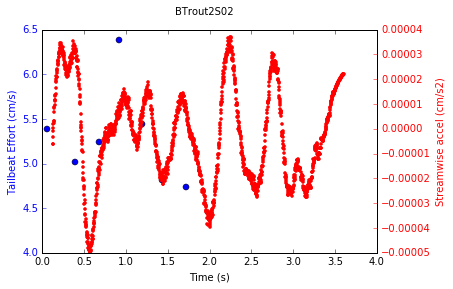

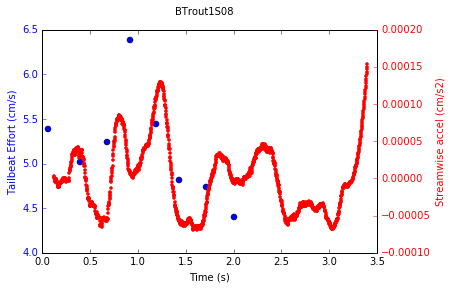

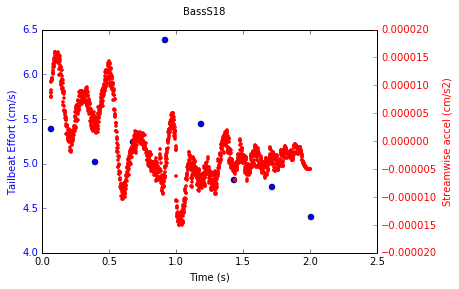

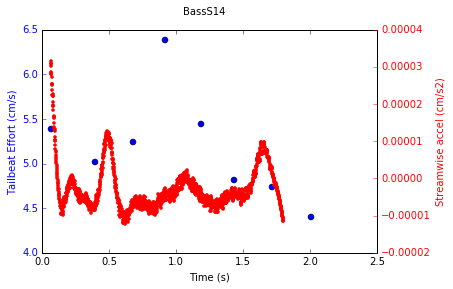

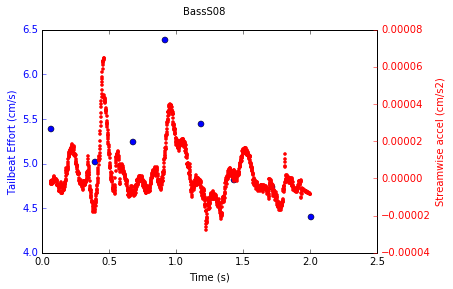

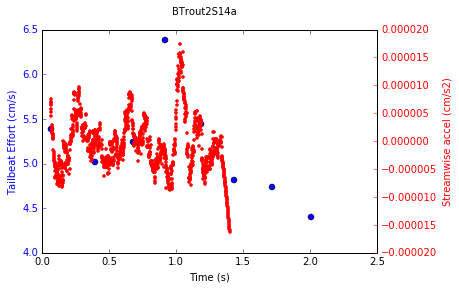

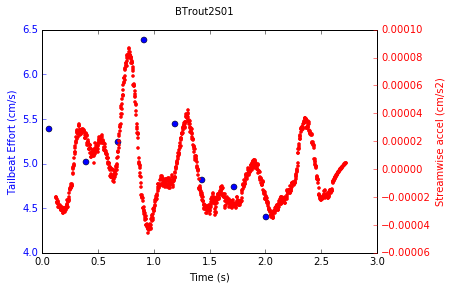

In [14]:
for trial in tracklist:    
    fig = plt.figure()
    fig.suptitle(tracklist[trial]['sequence'])
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.plot(fb_peaktimes, fb_effort, 'bo')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Tailbeat Effort (cm/s)', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    ax2.plot(tracklist[trial]['data'].index.values,
             -tracklist[trial]['data']['pt1x_a'], 'r.')
    ax2.set_ylabel('Streamwise accel (cm/s2)', color='r')
    ax2.tick_params('y', colors='r')

In [15]:
fb_peaktimes

array([ 0.062,  0.396,  0.678,  0.916,  1.188,  1.434,  1.716,  2.008])